<div style="text-align: right"><i>Ivy Zhang<br>2023</i></div>

The only thing I've copied over is the essential imports!

In [267]:
import math
import random
import graphviz as G
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Notes from implementing

### What is needed for an autograd engine?

I watched the lecture a few hours ago, so although it is still somewhat fresh in my mind, it's already a bit blurry so as to not be going off completely fresh memory. Either way, I hope that writing it from scratch will help me understand what I don't understand. Unknown unknowns are the scariest thing.

The general pattern surrounds a Value class. This class is able to hold values to begin with. Eventually, you'll need it to store gradients as well.

---

Now that it can store values and print them, I should also have it support some basic functions, like adding and multiplying Values together

---

These are simple enough, but something that the original video and Karpathy showed me, is that it's important to have visualizations for the work you're doing. I'm going to try and recreate some sort of visualizer for variables and their values to keep track of what's happening (not going off his code at all). To build off some sort of visualization will require that each node have a reference to the "children" that combined to create it. If it's just a value, the parent should be None, but once combined, then the parents are each of the two values

In order to build a graph, I ALSO need the operation being performed so that can be a node

---

The graph took SOOO long, ok, so basic gradient is when I calculate what happens, then you can also calulate the gradient from that thing.

---

To do back prop at a node, you need two things:
The gradient of the node that it feeds into and then you can figure it out based on the derivative of the current node

You want to start from your last node, set the gradient to 1,
then all the functions (add and multiply) should have functions that do calculate the gradient

In [268]:
# Go through and BFS to find all nodes and edges between them
def trace(node):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(node)
    return nodes, edges

# Visualize it as a large graph
def visualize_node(node) -> None:
    dot = G.Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
    
    nodes, edges = trace(node)
    ids = {}
    # Note that we can't just track based on label, they might be anonymous, so you should deal with that
    for node in nodes:
        ids[node] = str(node)
        dot.node(ids[node], f"{{{node.label} | data: {node.data} | grad: {node.grad}}}", shape='record')
        # If you have an operation, connect it to
        if node._op != '':        # Note to self, that empty string WON'T trigger this (can get rid of !=)
            dot.node(ids[node] + node._op, node._op)
            dot.edge(ids[node] + node._op, ids[node])

    # Instead of connecting directly, go to operation node
    for edge in edges:
        dot.edge(ids[edge[0]], ids[edge[1]] + edge[1]._op)

    return dot



In [269]:
class Value():
    """Stores values and the gradients"""
    # Note that label=None, so you can have "anonymous calls"
    def __init__(self, _data, _children=(), op='', label='') -> None:
        self.data = _data
        self.label = label
        self._prev = set(_children)
        self._op = op
        self.grad = 0.0
        self._backward = lambda: None

    # Little code, so I'm able to check the values in them
    def __repr__(self) -> str:
        return f"Value {self.label + ' ' if self.label != '' else self.label}(data = {self.data})"
    
    def __neg__(self):
        return self * -1
    
    # Learned something that it isn't the NODE that propagates it backwards, it's the out backward that does
    def __add__(self, other):
        assert(isinstance(other, (Value, int, float)))
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        assert(isinstance(other, (Value, int, float)))
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __exp__(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = math.exp(x) * out.grad
        out._backward = _backward
        return out        

    def __radd__(self, other):      # other + self
        return self + other

    def __rsub__(self, other):
        assert(isinstance(self, (int, float)))
        return Value(self) + -other
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data * (other - 1)) * out.grad
        
        out._backward = _backward
        return out

    def relu(self):
        out = Value(self.data if self.data > 0 else 0, (self, ), 'relu')

        def _backward():
            self.grad += (1 if self.data else 0) * out.grad
            
        out._backward = _backward
        return out
    
    def sigmoid(self):
        x = self.data
        sig = math.exp(x) / (1 + math.exp(x))
        out = Value(sig, (self, ), 'sigmoid')

        def _backward():
            self.grad = sig * (1 - sig) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        visited = set()
        ordering = []

        def topo_sort(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    if child not in visited:
                        topo_sort(child)
                ordering.append(node)

        topo_sort(self)

        self.grad = 1.0
        for node in reversed(ordering):
            node._backward()

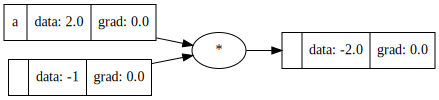

In [270]:
a = Value(2.0, label='a')
b = -a
visualize_node(b)

In [271]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = Value(-8.0, label='c')
d = a * b;      d.label = 'd'
e = d * c;      e.label = 'e'
f = e.relu();   f.label = 'f'

Now it's time to try and calculate gradients for the backward pass

In [272]:
# A node with itself will always just have a gradient of 1

# dx/dx = 1

e.grad = 1.0

# What is it for addition?
# d/dx(a + b) will always be 1, no matter the variable
# the thing to remember is chain rule, so that the gradient is how much you impact the variable you contribute to * how much that thing
# contributes to what it contributes to
# analogy: bike is 2x as fast as human, car is 4x as fast a bike, then car is 8x as much as human
# dCar/dHuman = dCar/dBike * dBike/dHuman = dCar/dHuman (the bikes cancel out)
# Also mistake he made in the video is that you should always **accumulate** gradients

d.grad = 1.0 * e.grad
c.grad = 1.0 * e.grad

# For multiplication, it is always the other variable (DATA) you multiply by

b.grad = a.data * d.grad
a.grad = b.data * d.grad

In [273]:
def gradient_test():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(3.0, label='b')
    c = Value(-2.0, label='c')
    d = a * b; d.label = 'd'
    e1 = d + c; e.label = 'e'

    a = Value(2.0, label='a')
    b = Value(3.0, label='b')
    c = Value(-2.0, label='c')
    d = a * b; d.label = 'd'
    e2 = d + c; e.label = 'e'

    print((e2.data - e1.data)/h)

gradient_test()

# It all checks out! Checked for each variable :)

0.0


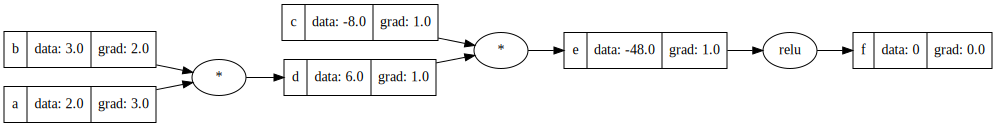

In [274]:
visualize_node(f)

In [366]:
class Module():
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
    
    def parameters(self):
        pass

class Neuron(Module):
    """Take a certain number of weights in, and then takes in a bias. This is a traditional perceptron"""
    def __init__(self, nin):
        # Xavier initialization
        self.w = [Value(random.uniform(-1/math.sqrt(nin), 1/math.sqrt(nin))) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w [nin], x [nin]
        # zip to pull them together
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.sigmoid()
        return out
    
    def parameters(self):
        return [self.b] + self.w
    
class Layer(Module):
    """Create a layer of Neurons to pass through"""
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params

class MLP(Module):
    def __init__(self, nin, layers):
        nc = [nin] + layers
        self.layers = [Layer(nc[i], nc[i+1]) for i in range(len(layers))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params

In [417]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, 0.0, 0.0, 1.0]

In [493]:
n = MLP(3, [6, 6, 1])

In [565]:

for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 0.004322783932224486
1 0.004317903437272624
2 0.004313033153250107
3 0.004308173049232594
4 0.004303323094417838
5 0.00429848325812516
6 0.004293653509794774
7 0.004288833818987251
8 0.004284024155382949
9 0.004279224488781392
10 0.004274434789100716
11 0.0042696550263771
12 0.004264885170764184
13 0.004260125192532535
14 0.0042553750620689945
15 0.004250634749876259
16 0.004245904226572184
17 0.00424118346288932
18 0.00423647242967434
19 0.004231771097887466
